In [1]:
from pathlib import Path

# Get the current working directory as a Path object
current_path = Path.cwd()
home_folder = 'evan_home'

# Traverse up the directory tree until you find the target folder
for parent in [current_path] + list(current_path.parents):
    if parent.name == home_folder:
        home_path = parent
        break
else:
    raise ValueError(f"Folder '{home_folder}' not found in the current working directory.")

print("Home Path:", home_path)
source_code_dir = home_path / 'Source_code'
dataset_dir = home_path / 'Dataset'


Home Path: c:\Users\evanlee\Documents\Bmi_NAS_evan\evan_home


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import pickle
import xgboost as xgb

In [3]:
import scanpy as sc

# adata = sc.read_h5ad(r"C:\Users\evanlee\Documents\Research_datasets\PBMC_Hao\GSE164378_Hao\Harmony_noZ\Hao_Harmony_test_no_scale.h5ad")
# adata = sc.read_h5ad('/Users/evanli/Documents/Research_datasets/PBMC_Hao/GSE164378_Hao/Harmony_noZ/Hao_Harmony_test_no_scale.h5ad')
adata = sc.read_h5ad(dataset_dir / 'PBMC_Hao/GSE164378_Hao/Harmony_noZ/Hao_Harmony_test_no_scale.h5ad')
print('Original adata:', adata.shape)
adata.obs['celltype.l1'] = adata.obs['celltype.l1'].str.replace(' ', '_')
label = adata.obs['celltype.l1'].tolist()
types = np.unique(label).tolist()
print('all cell types:', types)
print('====================')
# del adata


Original adata: (161764, 33538)
all cell types: ['B', 'CD4_T', 'CD8_T', 'DC', 'Mono', 'NK', 'other', 'other_T']


In [4]:
adata.obs.head()

,celltype.l1,celltype.l2,celltype.l3,Batch,donor,time,lane,Phase,nCount_ADT,nFeature_ADT,nCount_RNA,nFeature_RNA,leiden
L1_AAACCCAAGAAACTCA,Mono,CD14 Mono,CD14 Mono,Batch1,P2,7,L1,G1,7535,217,10823,2915,4
L1_AAACCCAAGACATACA,CD4_T,CD4 TCM,CD4 TCM_1,Batch1,P1,7,L1,G1,6013,209,5864,1617,2
L1_AAACCCACAACTGGTT,CD8_T,CD8 Naive,CD8 Naive,Batch1,P4,2,L1,S,6620,213,5067,1381,5
L1_AAACCCACACGTACTA,NK,NK,NK_2,Batch1,P3,7,L1,G1,3567,202,4786,1890,3
L1_AAACCCACAGCATACT,CD8_T,CD8 Naive,CD8 Naive,Batch1,P4,7,L1,G1,6402,215,6505,1621,5


## Read features

In [5]:
import os
# os.chdir(r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_batch_noZ\Level1\feature_selection_k3")
# os.chdir('/Users/evanli/Documents/EvanPys/Progress/PBMC_Hao_batch_noZ/Level1/feature_selection_k3')
os.chdir(source_code_dir / 'PBMC_Hao_batch_noZ/Level1/feature_selection_k3')

features_dict = {}
# Read features for each celltype
for celltype in types:
    try:
        feature_df = pd.read_csv(f'{celltype}_features.txt', names=['Gene', 'Weight', 'Tendency'], sep='\t')
        features_dict[celltype] = feature_df
    except:
        print('skipping:', celltype)
        continue

In [6]:
features_dict.keys()

dict_keys(['B', 'CD4_T', 'CD8_T', 'DC', 'Mono', 'NK', 'other', 'other_T'])

In [7]:
count_df = pd.DataFrame(columns=['Feature_count', 'Positive_feature_count'])
for celltype in features_dict.keys():
    feature_df = features_dict[celltype]
    feature_count = feature_df.shape[0]
    positive_count = feature_df[feature_df['Tendency'] == 1].shape[0]
    count_df.loc[celltype] = [feature_count, positive_count]
count_df

,Feature_count,Positive_feature_count
B,19,10
CD4_T,201,95
CD8_T,23,9
DC,50,23
Mono,50,20
NK,33,17
other,5,3
other_T,247,112


## LR

In [8]:
import os
import sys
import importlib
sys.path.append(str(source_code_dir))
# sys.path.append('/Users/evanli/Documents/EvanPys/Progress')
# sys.path.append('/home/jovyan/work/GitHub/EvanPys/Progress')
# sys.path.append(r'C:\Users\evanlee\Documents\GitHub\EvanPys\Progress')
from evan_library import evan_models as emd
importlib.reload(emd)


<module 'evan_library.evan_models' from 'c:\\Users\\evanlee\\Documents\\Bmi_NAS_evan\\evan_home\\Source_code\\evan_library\\evan_models.py'>

In [9]:
evan_lr = emd.EvanModels(adata, features_dict, level='l1')

In [10]:
all_metrics_df, cv_results_dict, likelihood_dict = evan_lr.run_LR_kfold_for_types(save_path='')

K-fold CV for: B
Cross-validation...


/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_m

likelihood > 0.5: 13790
[0.9996213623542243, 0.9981883149839714, 0.997373188405797, 0.9977795945336936, 0.9999872974029607, 0.9998366320033842, 0.9975733207784373]
K-fold CV for: CD4_T
Cross-validation...


/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_m

likelihood > 0.5: 41023
[0.9699175388772161, 0.9406263843032668, 0.9407030224794705, 0.9406588687106374, 0.9940975980992561, 0.9827932105759475, 0.9205158923385988]
K-fold CV for: CD8_T
Cross-validation...


/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_m

likelihood > 0.5: 24135
[0.9757362235377418, 0.9457842028798703, 0.8973251533742331, 0.92091423928482, 0.9917232530025238, 0.9680525711586718, 0.9070355540689841]
K-fold CV for: DC
Cross-validation...


/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


likelihood > 0.5: 3548
[0.9985086282671457, 0.9708313980434987, 0.9616864111498258, 0.9662257743345352, 0.9998589706283516, 0.9943259802019186, 0.9654805856747224]
K-fold CV for: Mono
Cross-validation...


/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


likelihood > 0.5: 49593
[0.9936249614321492, 0.9838887585189402, 0.9952561039983626, 0.9895395935728072, 0.9988006529164275, 0.9954638774279821, 0.9849890935094591]
K-fold CV for: NK
Cross-validation...


/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


likelihood > 0.5: 18593
[0.9929372352304565, 0.9704749030230169, 0.9682540618635207, 0.969358711471369, 0.998744016904783, 0.9946200685882503, 0.9653710180915505]
K-fold CV for: other
Cross-validation...


/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


likelihood > 0.5: 2447
[0.9917549550390226, 0.9322685683092672, 0.6608500247483914, 0.7732520739300918, 0.9331320578823791, 0.8002376559470576, 0.7811074669599373]
K-fold CV for: other_T
Cross-validation...
likelihood > 0.5: 6293
[0.9899158560684457, 0.9101377862730127, 0.8429424590972161, 0.8752177067854596, 0.9934023764027418, 0.9336434981324813, 0.8706849755366826]


In [11]:
all_metrics_df

,Accuracy,Precision,Recall,F1-score,ROC-AUC,PR-AUC,MCC
B,0.999621,0.998188,0.997373,0.997780,0.999987,0.999837,0.997573
CD4_T,0.969918,0.940626,0.940703,0.940659,0.994098,0.982793,0.920516
CD8_T,0.975736,0.945784,0.897325,0.920914,0.991723,0.968053,0.907036
DC,0.998509,0.970831,0.961686,0.966226,0.999859,0.994326,0.965481
Mono,0.993625,0.983889,0.995256,0.989540,0.998801,0.995464,0.984989
NK,0.992937,0.970475,0.968254,0.969359,0.998744,0.994620,0.965371
other,0.991755,0.932269,0.660850,0.773252,0.933132,0.800238,0.781107
other_T,0.989916,0.910138,0.842942,0.875218,0.993402,0.933643,0.870685


## Plot classifier K-fold CV metrics

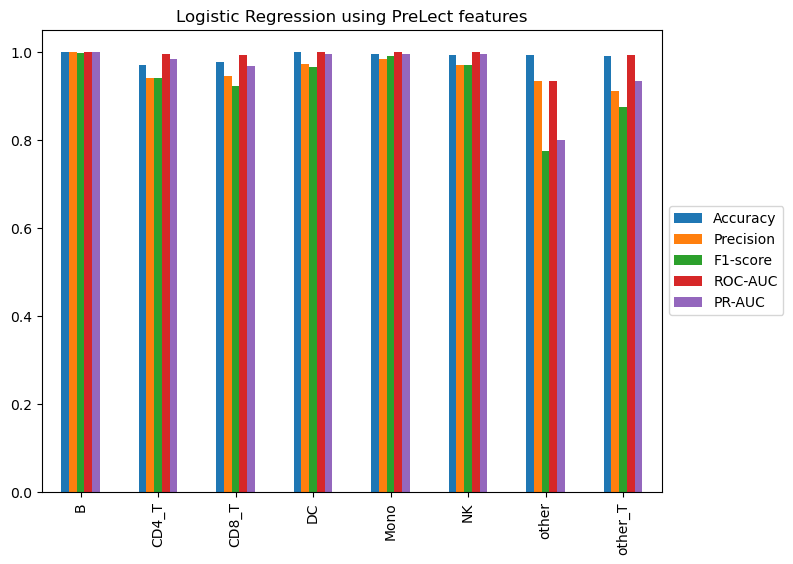

In [18]:
# cols = ['Precision', 'F1-score', 'ROC-AUC', 'PR-AUC', 'MCC']
cols = ['Accuracy', 'Precision', 'F1-score', 'ROC-AUC', 'PR-AUC']

# Plot metrics for each celltype
ax = all_metrics_df[cols].plot.bar(rot=90, figsize=(8,6), title='Logistic Regression using PreLect features')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

In [13]:
cv_results_dict

{'B': {'fit_time': [0.9654040336608887,
   0.5181849002838135,
   0.46698689460754395,
   0.36917781829833984,
   0.39061403274536133],
  'score_time': [0.06880807876586914,
   0.0681159496307373,
   0.06870412826538086,
   0.07047724723815918,
   0.06855201721191406],
  'test_accuracy': [0.9994977398292315,
   0.9996136310949695,
   0.9996136310949695,
   0.9996909048759756,
   0.9996909048759756],
  'test_precision': [0.9981842941443486,
   0.9990917347865577,
   0.9986388384754991,
   0.9968383017163505,
   0.9981884057971014],
  'test_recall': [0.9959239130434783,
   0.9963768115942029,
   0.9968297101449275,
   0.9995471014492754,
   0.9981884057971014],
  'test_f1_score': [0.9970528224892314,
   0.997732426303855,
   0.997733454215775,
   0.9981908638625057,
   0.9981884057971014],
  'test_roc_auc': [0.999983223145555,
   0.9999939547207051,
   0.9999918503513302,
   0.9999737145134453,
   0.9999937442837676],
  'test_average_precision': [0.9997878649229092,
   0.9999371498132231

In [14]:
confusion_matrix = evan_lr.assign_likelihoods(likelihood_dict)
confusion_matrix

Accuracy: 0.9729667911278158
micro Precision: 0.9729667911278158
micro F1 Score: 0.9729667911278158
macro Precision: 0.9658469234733695
macro F1 Score: 0.9497472289679464
weighted Precision: 0.9728147260605855
weighted F1 Score: 0.9725486953167571


Predicted,B,CD4_T,CD8_T,DC,Mono,NK,other,other_T
True,,,,,,,,
B,13785,0,3,0,9,2,1,0
CD4_T,2,40424,352,0,4,8,11,200
CD8_T,0,1081,23891,0,0,87,2,408
DC,0,0,0,3436,149,0,4,0
Mono,5,8,4,65,48831,10,87,0
NK,0,15,93,0,2,18473,0,81
other,20,164,58,8,539,45,2583,25
other_T,0,239,445,0,1,134,2,5968


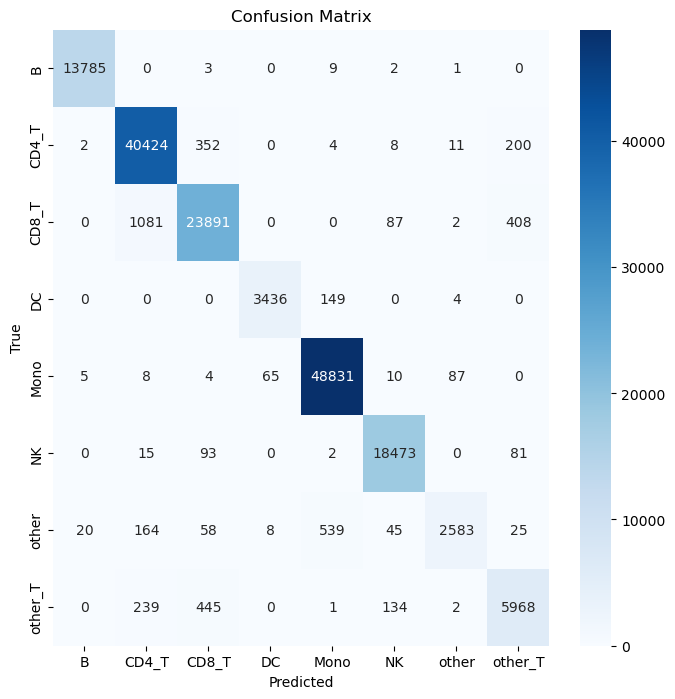

In [15]:
evan_lr.plot_confusion_matrix(confusion_matrix)

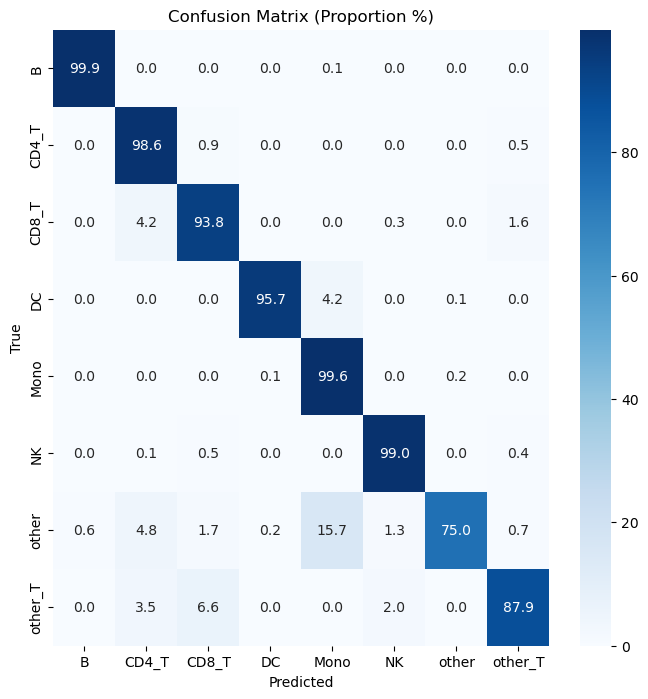

In [16]:
evan_lr.plot_confusion_matrix_proportion(confusion_matrix)